In [82]:
import pandas as pd
import numpy as np
from collections import Counter
import math
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler

from utils.utils import eval_run, plot_conf_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score


In [2]:
table_1 = pd.read_csv(r"data\table_1.csv", sep=';')
table_2 = pd.read_csv(r"data\table_2.csv", sep=';')

In [3]:
table_2

,POUG,TRE,ID,ZUB,VOL,UIO,VBNM,Type,OIN
0,1,1.750,0,t,f,uuuu,t,n,17.92
1,0,0.290,1,f,f,wwww,f,n,16.92
2,1,0.000,2,f,f,wwww,t,n,31.25
3,0,0.335,3,f,f,uuuu,f,n,48.17
4,0,0.500,4,t,f,wwww,f,n,32.33
...,...,...,...,...,...,...,...,...,...
4065,14,5.500,3314,f,t,uuuu,t,y,52.83
4066,7,0.750,999,f,t,uuuu,t,y,19.17
4067,0,5.000,2415,t,t,uuuu,f,y,36.75
4068,0,0.835,511,f,t,wwww,f,y,23.25


### First, we will try to merge the two tables by the unique ID of the samples.

In [4]:
id_order = list(table_2['ID'])
print(len(id_order))
print(len(set(id_order)))

4070
3700


There are duplicates in the data; remove them (first making sure that they are complete duplicates):

In [5]:
table_2[table_2['ID']==305]

,POUG,TRE,ID,ZUB,VOL,UIO,VBNM,Type,OIN
305,0,3.25,305,f,f,uuuu,f,n,22.25
3784,0,3.25,305,f,f,uuuu,f,n,22.25
3827,0,3.25,305,f,f,uuuu,f,n,22.25
4044,0,3.25,305,f,f,uuuu,f,n,22.25


Remove duplicates

In [6]:
table_2 = table_2.drop_duplicates(subset=['ID'])
table_1 = table_1.drop_duplicates(subset=['ID'])

Order the IDs in table one in the same way as in table 2 to further merge them.

In [7]:
id_order = list(table_2['ID'])
table_1['ID'] = pd.Categorical(table_1['ID'], categories=id_order, ordered=False)
data = pd.merge(table_1, table_2, on='ID', how='inner')

In [8]:
data

,ID,UKL,GJAH,ZIK,HUI,ERZ,CDx,BJZHD,NKJUD,LPI,BJKG,POUG,TRE,ZUB,VOL,UIO,VBNM,Type,OIN
0,0,160,oooo,x,oooo,www,5.0,vvvv,80.0,800000.0,qqqq,1,1.750,t,f,uuuu,t,n,17.92
1,1,153,rrr,NaN,uuu,pppp,0.0,mmm,200.0,2000000.0,qqqq,0,0.290,f,f,wwww,f,n,16.92
2,2,5,oooo,x,oooo,www,19.0,hh,96.0,960000.0,hh,1,0.000,f,f,wwww,t,n,31.25
3,3,9,oooo,NaN,oooo,www,120.0,kkk,0.0,0.0,qqq,0,0.335,f,f,uuuu,f,n,48.17
4,4,40,oooo,y,oooo,www,0.0,mmm,232.0,2320000.0,qqqq,0,0.500,t,f,wwww,f,n,32.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,3695,74,oooo,x,oooo,www,26726.0,sss,NaN,NaN,qqqq,5,2.710,f,t,uuuu,t,y,18.75
3696,3696,179,oooo,x,oooo,www,0.0,sss,120.0,1200000.0,qqqq,5,8.500,t,t,uuuu,t,y,23.50
3697,3697,82,oooo,NaN,oooo,www,221.0,vvvv,0.0,0.0,qqqq,12,4.500,t,t,wwww,t,y,34.17
3698,3698,13,oooo,NaN,oooo,www,3.0,yyy,100.0,1000000.0,qqqq,5,3.750,t,t,wwww,t,y,27.83


### Let's examine each feature type

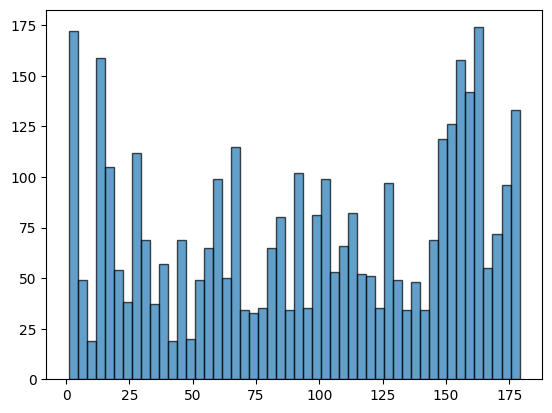

1
179
95.68837837837837
99.0
0    1
Name: UKL, dtype: int64


In [9]:
plt.hist(list(data['UKL']), bins=50, edgecolor='black', alpha=0.7)
plt.show()
print(min(list(data['UKL'])))
print(max(list(data['UKL'])))
print(np.mean(list(data['UKL'])))
print(data['UKL'].median())
print(data['UKL'].mode())

In [10]:
Counter(list(data["GJAH"]))

Counter({'oooo': 3055, 'rrr': 549, nan: 64, 'ii': 32})

In [11]:
Counter(list(data["ZIK"]))

Counter({'x': 1023, nan: 2145, 'y': 532})

ZIK feature seems not so useful, as the majority samples don't have any value for it (more than half).

We can turn it into another feature where having a value or not is a feature itself.

In [12]:
data['ZIK_is_missing'] = data['ZIK'].isna()
data = data.drop(columns=['ZIK'])

I checked how different options reflect on accuracy/f-score:

- Removing ZIK variable: 
    - Logistic regression: Accuracy: 0.9473, F1_score: 0.9400

- Transforming ZIK into a new feature:
    - Logistic regression: Accuracy: 0.9541, F1_score: 0.9498

Based on that, I proceed with creating a new variable "ZIK_is_missing".

In [13]:
Counter(list(data["HUI"]))

Counter({'oooo': 3430, 'uuu': 189, 'rrr': 81})

In [14]:
Counter(list(data["ERZ"]))

Counter({'www': 3055, 'pppp': 549, nan: 64, 'nnn': 32})

0.0
100000.0
2246.705945945946
113.0
0    0.0
Name: CDx, dtype: float64


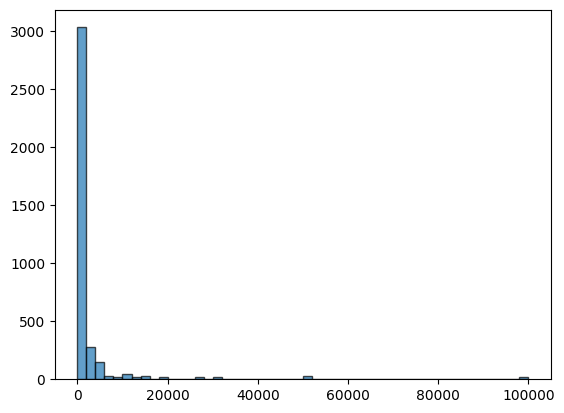

In [14]:
print(min(list(data['CDx'])))
print(max(list(data['CDx'])))
print(np.mean(list(data['CDx'])))
print(data['CDx'].median())
print(data['CDx'].mode())


plt.hist(list(data['CDx']), bins=50, edgecolor='black', alpha=0.7)
plt.show()

In [15]:
Counter(list(data["BJZHD"]))

Counter({'vvvv': 787,
         'mmm': 170,
         'hh': 136,
         'kkk': 191,
         'lll': 39,
         'sss': 612,
         'yyy': 457,
         'ooo': 179,
         'ee': 553,
         'xxx': 33,
         'zzz': 340,
         'ggg': 137,
         nan: 66})

0.0
1160.0
nan
120.0
0    0.0
Name: NKJUD, dtype: float64


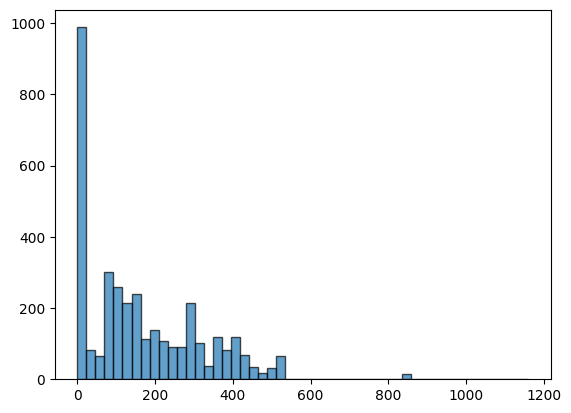

In [17]:
print(min(list(data['NKJUD'])))
print(max(list(data['NKJUD'])))
print(np.mean(list(data['NKJUD'])))
print(data['NKJUD'].median())
print(data['NKJUD'].mode())

plt.hist(list(data['NKJUD']), bins=50, edgecolor='black', alpha=0.7)
plt.show()

0.0
11600000.0
nan
1200000.0
0    0.0
Name: LPI, dtype: float64


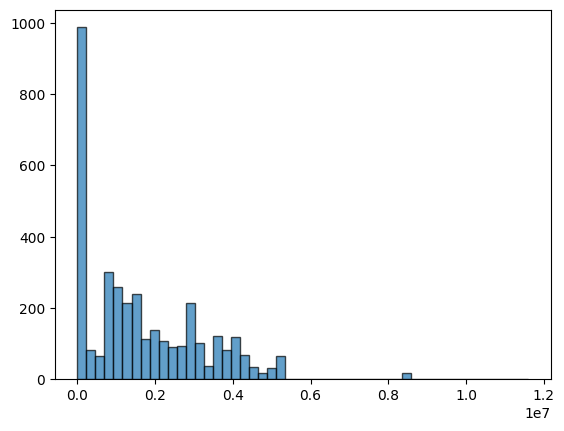

In [18]:
print(min(list(data['LPI'])))
print(max(list(data['LPI'])))
print(np.mean(list(data['LPI'])))
print(data['LPI'].median())
print(data['LPI'].mode())

plt.hist(list(data['LPI']), bins=50, edgecolor='black', alpha=0.7)
plt.show()

In [19]:
Counter(list(data["BJKG"]))

Counter({'qqqq': 2015,
         'hh': 154,
         'qqq': 17,
         'hhhh': 970,
         'lll': 37,
         'yy': 359,
         'ppp': 33,
         'bbb': 49,
         nan: 66})

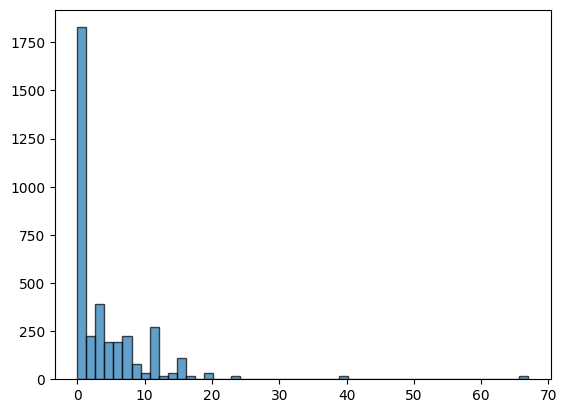

In [20]:
Counter(list(data["POUG"]))

plt.hist(list(data['POUG']), bins=50, edgecolor='black', alpha=0.7)
plt.show()

0.0
28.5
3.4394959459459455
1.75
0.0


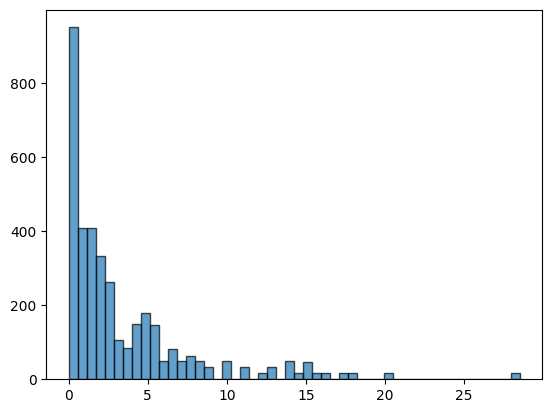

In [21]:
print(min(list(data['TRE'])))
print(max(list(data['TRE'])))
print(np.mean(list(data['TRE'])))
print(data['TRE'].median())
print(data['TRE'].mode().iloc[0])

plt.hist(list(data['TRE']), bins=50, edgecolor='black', alpha=0.7)
plt.show()


In [22]:
Counter(list(data["ZUB"]))

Counter({'t': 1776, 'f': 1924})

In [23]:
Counter(list(data["VOL"]))

Counter({'f': 529, 't': 3171})

In [24]:
Counter(list(data["UIO"]))

Counter({'uuuu': 1279, 'wwww': 2382, nan: 39})

In [25]:
Counter(list(data["VBNM"]))

Counter({'t': 2239, 'f': 1461})

In [26]:
print(min(list(data['OIN'])))
print(max(list(data['OIN'])))
print(np.mean(list(data['OIN'])))
print(data['OIN'].median())
print(data['OIN'].mode())

13.75
80.25
nan
28.67
0    23.25
Name: OIN, dtype: float64


In [27]:
Counter(list(data["Type"]))

Counter({'n': 276, 'y': 3424})

##### Looking at our labels, we see that there is a major class imbalance. Even if we build a model that only predicts yes", we will be right in almost 92% percent of cases.

We will deal with this later by trying different strategis:

- assigning higher penalty for mistakes on a smaller class
- resampling

In [17]:
100 - 276/3424*100

91.9392523364486

Now we impute missing values of the features, in this case by replacing them with the mode (most commonly met value).

In [18]:
for index, row in data.iterrows():
    for column_name, value in row.items():
        if isinstance(value, (int, float)) and math.isnan(value):
            try:
                mode_value = data[column_name].mode().iloc[0]
                data.at[index, column_name] = mode_value
            except TypeError:
                continue

Check if numerical variables are correlated. Our predictors should be independent from each other as much as possible.

In [19]:
feature_floats = data.select_dtypes(include=['float64'])
feature_names = list(feature_floats.columns)
correlations = data[feature_names].corr()

In [20]:
correlations

,CDx,NKJUD,LPI,TRE,OIN
CDx,1.000000,0.145232,0.145232,-0.004123,-0.007921
NKJUD,0.145232,1.000000,1.000000,-0.195718,-0.149966
LPI,0.145232,1.000000,1.000000,-0.195718,-0.149966
TRE,-0.004123,-0.195718,-0.195718,1.000000,0.511143
OIN,-0.007921,-0.149966,-0.149966,0.511143,1.000000


There doesn't seem to be a large correlation between numerical variables; only OIN and TRE have a correlation of around 0.5, which is not extremely high.

### Create dummy variables for categorical variables

In [21]:
print(data.dtypes)

ID                  int64
UKL                 int64
GJAH               object
HUI                object
ERZ                object
CDx               float64
BJZHD              object
NKJUD             float64
LPI               float64
BJKG               object
POUG                int64
TRE               float64
ZUB                object
VOL                object
UIO                object
VBNM               object
Type               object
OIN               float64
ZIK_is_missing       bool
dtype: object


In [22]:
features_object = data.select_dtypes(include=['object', "bool"])
features_object_names = list(features_object.columns)

In [23]:
data_with_dummies = pd.get_dummies(data, columns=features_object_names, drop_first=True) # drop_first=True to avoid multicollinearity

Now we deal with outliers: if they are more than 2 standart deviations away from the mean, we cap them to the +-2SD range

In [24]:
features_numerical = data.select_dtypes(include=['int64', 'float64'])
features_numerical_names = list(features_numerical.columns)
#drop the ID column
features_numerical_names = features_numerical_names[1:]

In [25]:
features_numerical_names

['UKL', 'CDx', 'NKJUD', 'LPI', 'POUG', 'TRE', 'OIN']

In [26]:
# now we apply Winsorization to each numerical feature
for feature in features_numerical_names:
    data_with_dummies[feature] = winsorize(data_with_dummies[feature], limits=[0.05, 0.05])

Now we do data normalization. 

We use StandardScaler (Standardization) instead of MinMaxScaler (from 0 to 1) because if there are outliers, the majority of the values will be squeezed in a small range. Also we don't know from the data what are "natural bounds" of variables (like range of the pixel values, temperature, etc.)

In [27]:
scaler = StandardScaler()
data_with_dummies[features_numerical_names] = scaler.fit_transform(data_with_dummies[features_numerical_names])

# to convert True/False into 0/1
boolean_columns = data_with_dummies.select_dtypes(include='bool').columns
data_with_dummies[boolean_columns] = data_with_dummies[boolean_columns].astype(int)

### We run correlation analysis again

In [28]:
correlation_matrix = data_with_dummies.corr()

In [29]:
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr = upper_triangle[upper_triangle > 0.7]

print("Correlations greater than 0.7:")
print(high_corr.dropna(how='all').dropna(axis=1, how='all'))

Correlations greater than 0.7:
           LPI  ERZ_pppp  ERZ_www   BJKG_hh
NKJUD      1.0       NaN      NaN       NaN
GJAH_oooo  NaN       NaN      1.0       NaN
GJAH_rrr   NaN       1.0      NaN       NaN
BJZHD_hh   NaN       NaN      NaN  0.822299


##### We see perfect correlation between NKJUD & LPI, GJAH_rrr and ERZ_pppp, and GJAH_oooo and ERZ_www.

We will remove one variable in each pair and see how it affects the model performance. We will use a function that will evaluate both set of predictors - with and without collinearity: eval_run

In [30]:
data_dummies_dropped_collinear = data_with_dummies.drop(columns=['NKJUD', "ERZ_pppp", "ERZ_www"])

Results of the analysis:

- **Logistic Regression**: 

    - Preserve collinear vars: 
        - Accuracy: 0.9541, F1_score: 0.9498
    - Remove collinear vars: 
        - Accuracy: 0.9527, F1_score: 0.9481

- **Ridge Classification**
    - Preserve collinear vars: 
        - Accuracy: 0.9432, F1_score: 0.9385
    - Remove collinear vars: 
        - Accuracy: 0.9446, F1_score: 0.9397

- **Random forest**
    - Preserve collinear vars: 
        - Accuracy: **0.9757**, F1_score: **0.9741**
    - Remove collinear vars: 
        - Accuracy: **0.9757**, F1_score: **0.9741**


##### For some reason, a model with collinear variables performs better on a test set on logistic regression and Ridge classification. 

However, the less complex our model is, the more interpretable it is, and the performance loss isn't drastic.

Based on the high performance of **Random forests**, I decided to proceed with them. Not only did they have a high accuracy, but also highest F1-score, and were able to detect the most instances of a minority class.

They might also be good since they don't assume a linear relationship in our data.

Accuracy: 0.9757
F1_score: 0.9741


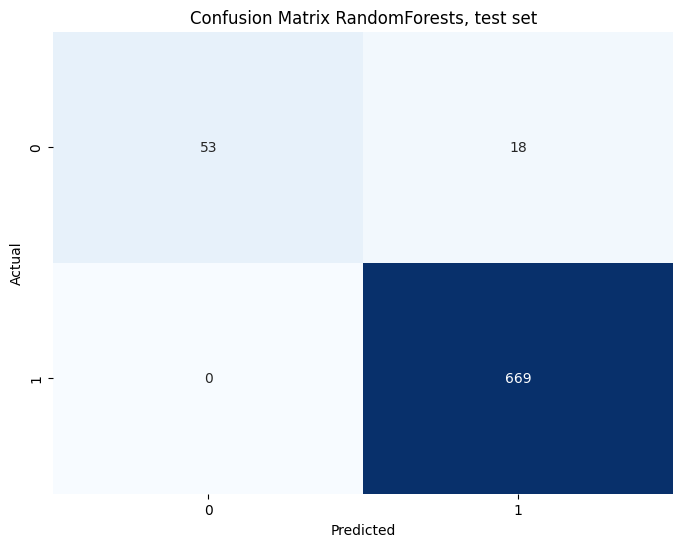

In [35]:
eval_run(data_with_dummies, model='random_forest')

Accuracy: 0.9757
F1_score: 0.9741


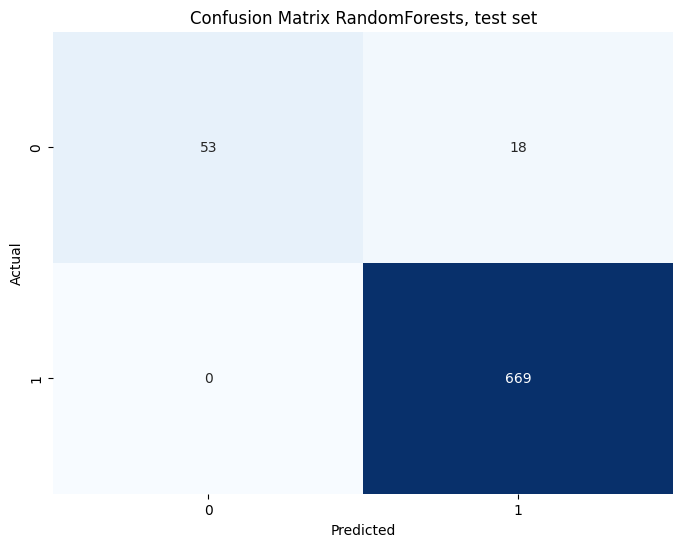

In [36]:
eval_run(data_dummies_dropped_collinear, model='random_forest')

### Now we will try to enhance the Random Forests performance

#### 1. Handling class imbalance

We will add a class_weight = 'balanced' parameter to increase punishment for less represented labels.

In [64]:
# These are the weights class_weight = 'balanced' will provide.
print("Error weight to class 'no':", 3700/(2*276))
print("Error weight to class 'yes':", 3700/(2*3424))

Error weight to class 'no': 6.702898550724638
Error weight to class 'yes': 0.540303738317757


In [37]:
predictors = list(data_dummies_dropped_collinear.columns)
predictors.remove("ID")
predictors.remove("Type_y")

X = data_dummies_dropped_collinear[predictors]
y = data_dummies_dropped_collinear['Type_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Find optimal hyperparameters using GridSearch

- number of trees - optimal number of trees
- depth - optimal depth to prevent overfitting
- maximum number of features - maximum number of features to consider at each split

### First let's optimize for accuracy

In [81]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25],
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_features': list(range(1, len(predictors), 5))
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score}")

Best parameters: {'max_depth': 20, 'max_features': 6, 'n_estimators': 50}
Best cross-validated score: 0.9881756756756757


### Now let's optimize for F1-score

In [83]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25],
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_features': list(range(1, len(predictors), 5))
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

f1_scorer = make_scorer(f1_score)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters f1: {best_params}")
print(f"Best cross-validated score f1: {best_score}")

Best parameters f1: {'max_depth': 20, 'max_features': 6, 'n_estimators': 50}
Best cross-validated score f1: 0.9936896231273664


Best hyperparameters coincide for F1-score and accuracy: 'max_depth': 20, 'max_features': 6, 'n_estimators': 50.

Let's build the model with these parameters and inspect the confusion matrix.

Accuracy: 0.9770
F1_score: 0.9756


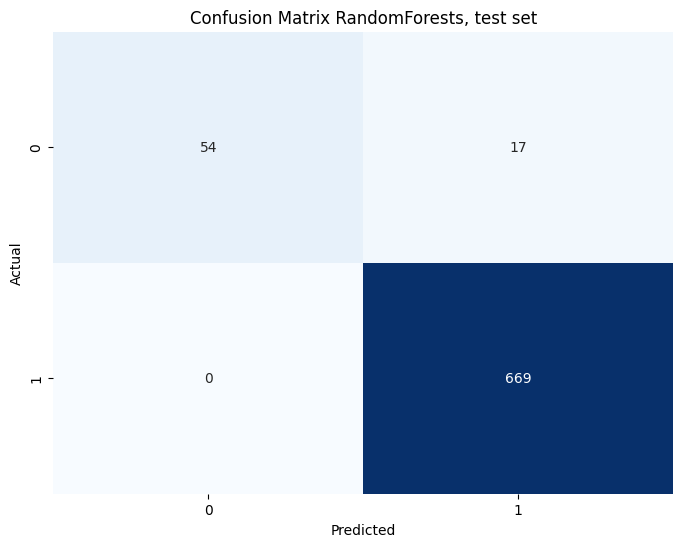

In [85]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=50, max_depth=20, max_features=6, random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plot_conf_matrix(conf_matrix, y_test, "RandomForests")

We were able to increase accuracy from 0.9757 to 0.9770, and f1-score from 0.9756 to 0.9741.

In [87]:
importances = rf.feature_importances_

# Assuming your feature names are stored in a list called feature_names
feature_names = X.columns  # or list of feature names

# Create a DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(importance_df)

                Feature  Importance
29                VOL_t    0.348241
4                   TRE    0.097208
0                   UKL    0.069255
3                  POUG    0.068008
1                   CDx    0.067759
2                   LPI    0.056992
5                   OIN    0.053474
31               VBNM_t    0.041375
28                ZUB_t    0.013779
8               HUI_rrr    0.013165
22            BJKG_hhhh    0.012807
30             UIO_wwww    0.012740
6             GJAH_oooo    0.012725
7              GJAH_rrr    0.012118
11             BJZHD_hh    0.011261
17           BJZHD_vvvv    0.010967
32  ZIK_is_missing_True    0.010267
21              BJKG_hh    0.010173
19            BJZHD_yyy    0.009730
12            BJZHD_kkk    0.009100
26            BJKG_qqqq    0.008832
16            BJZHD_sss    0.008080
9               HUI_uuu    0.007730
20            BJZHD_zzz    0.007427
14            BJZHD_mmm    0.006325
27              BJKG_yy    0.006083
15            BJZHD_ooo    0

The most influential feature seems to be  VOL_t

Try to build a model on that only.

In [74]:
n_estimators_range = [10, 50, 100, 200, 300, 400, 500]
f1_scores = []
accuracies = []
for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, class_weight='balanced')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    accuracies.append(accuracy)

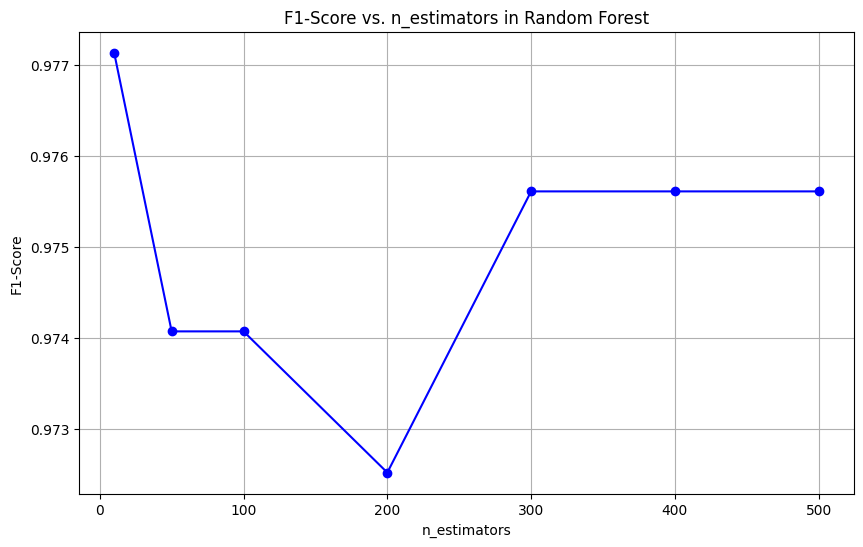

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, f1_scores, marker='o', linestyle='-', color='b')
plt.title('F1-Score vs. n_estimators in Random Forest')
plt.xlabel('n_estimators')
plt.ylabel('F1-Score')
plt.grid(True)
plt.show()

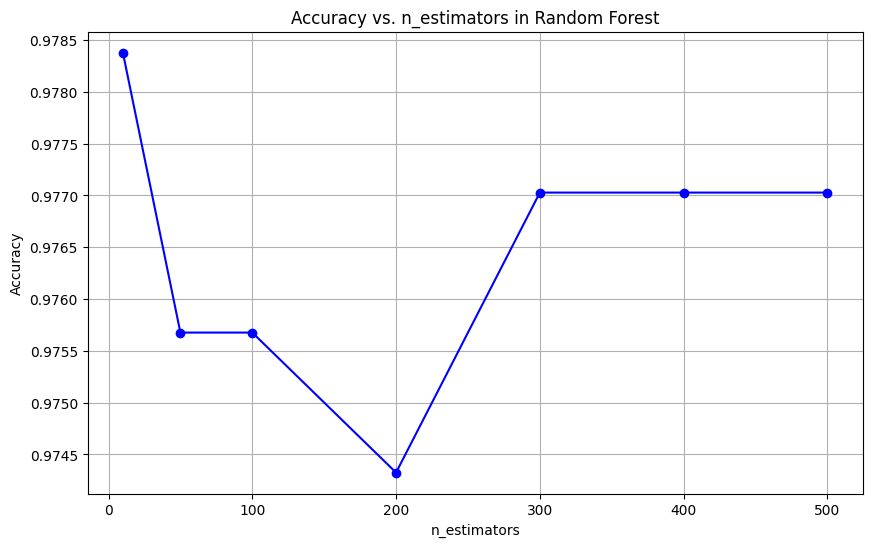

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. n_estimators in Random Forest')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### 3. Try doing splits at a limited number of features every time

In [77]:
f1_scores_features = []
accuracies_features = []
max_features_list = []
for l in range(1, len(predictors), 5):
    max_features_list.append(l)
    rf = RandomForestClassifier(n_estimators=10, max_features=l, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores_features.append(f1)
    accuracies_features.append(accuracy)


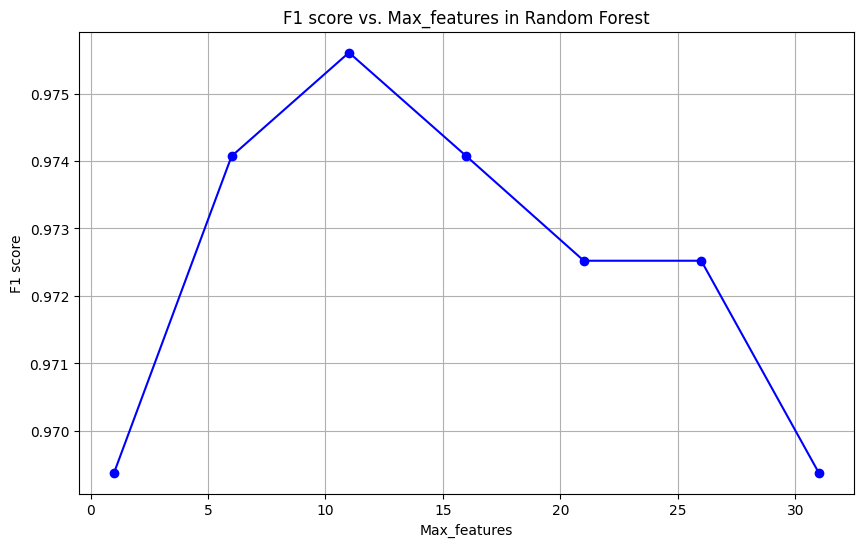

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(max_features_list, f1_scores_features, marker='o', linestyle='-', color='b')
plt.title('F1 score vs. Max_features in Random Forest')
plt.xlabel('Max_features')
plt.ylabel('F1 score')
plt.grid(True)
plt.show()

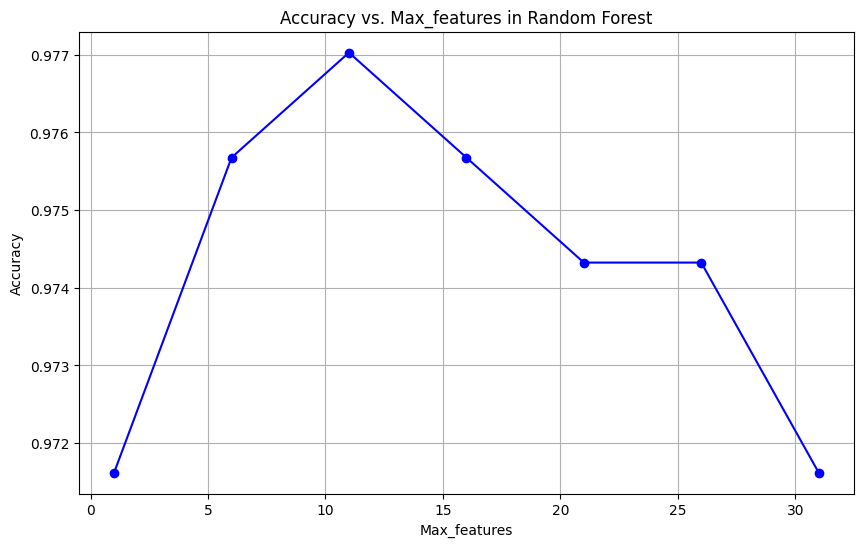

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(max_features_list, accuracies_features, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Max_features in Random Forest')
plt.xlabel('Max_features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### 4. Try different tree depth to prevent overfitting

In [ ]:
depth_range = [3, 5, 7, 10, 15, 20]
depths = []
accuracies_depth = []
f1_depths = []

for depth in depth_range:
    model = RandomForestClassifier(max_depth=depth, n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    depths.append(depth)
    accuracies.append(accuracy)
    print(f"max_depth: {depth}, Accuracy: {accuracy}")
    
    
    rf = RandomForestClassifier(max_depth=depth, n_estimators=100, max_features=6, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores_features.append(f1)
    accuracies_features.append(accuracy)

As a result of the analysis, seems like n_estimators = 100 and max_features=6 are bringing the best f-score and accuracy. Let's try to combine these parameters.

Accuracy: 0.9770
F1_score: 0.9756


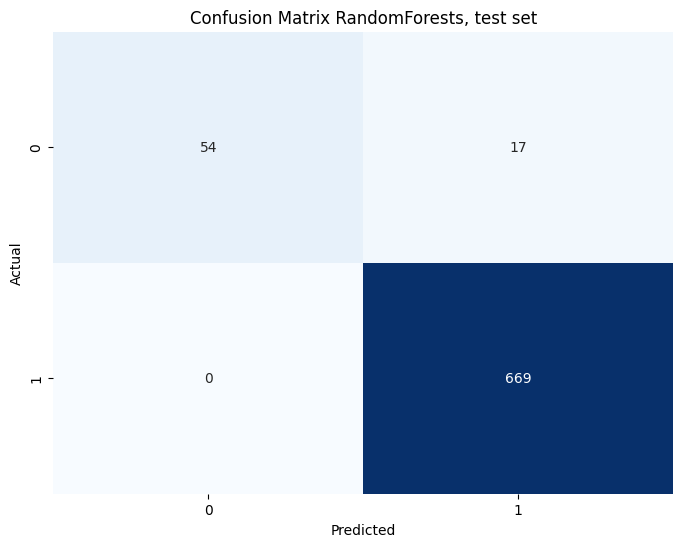

In [78]:
rf = RandomForestClassifier(n_estimators=100, max_features=6, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f"F1_score: {f1:.4f}")
plot_conf_matrix(conf_matrix, y_test, "RandomForests")


In [79]:
importances = rf.feature_importances_

In [80]:
importances

array([7.10936581e-02, 7.06766013e-02, 6.09503080e-02, 8.89238687e-02,
       1.10175638e-01, 5.26987488e-02, 1.26030048e-02, 1.16435655e-02,
       1.36821095e-02, 7.07217369e-03, 1.51534320e-03, 1.11285086e-02,
       7.66092698e-03, 1.82150789e-04, 5.45081790e-03, 5.85770025e-03,
       8.15867861e-03, 1.02090303e-02, 1.97340696e-04, 9.46325611e-03,
       1.02712428e-02, 9.09809037e-03, 1.36333415e-02, 2.24069966e-03,
       2.35232737e-03, 1.51788017e-03, 9.57674390e-03, 4.76679035e-03,
       1.36675113e-02, 3.16238921e-01, 1.25045341e-02, 3.40260939e-02,
       1.07623935e-02])

In [84]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
print(lasso.coef_)

[-0.          0.00532862 -0.          0.00568976  0.00265705 -0.
  0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
 -0.         -0.          0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.31892001
 -0.          0.          0.        ]


In [89]:
# Get the feature names (assuming X is a pandas DataFrame)
feature_names = X.columns
# Get the coefficients from the Lasso model
coefficients = lasso.coef_

# Create a DataFrame to display feature names alongside their corresponding coefficients
lasso_results = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the results by the magnitude of coefficients
lasso_results = lasso_results.sort_values(by='Coefficient', ascending=False)

# Print or display the DataFrame
print(lasso_results)

                Feature  Coefficient
29                VOL_t     0.318920
3                  POUG     0.005690
1                   CDx     0.005329
4                   TRE     0.002657
0                   UKL    -0.000000
24             BJKG_ppp     0.000000
20            BJZHD_zzz     0.000000
21              BJKG_hh    -0.000000
22            BJKG_hhhh     0.000000
23             BJKG_lll     0.000000
26            BJKG_qqqq     0.000000
25             BJKG_qqq     0.000000
18            BJZHD_xxx    -0.000000
27              BJKG_yy     0.000000
28                ZUB_t     0.000000
30             UIO_wwww    -0.000000
31               VBNM_t     0.000000
19            BJZHD_yyy    -0.000000
16            BJZHD_sss     0.000000
17           BJZHD_vvvv     0.000000
15            BJZHD_ooo    -0.000000
14            BJZHD_mmm    -0.000000
13            BJZHD_lll    -0.000000
12            BJZHD_kkk    -0.000000
11             BJZHD_hh    -0.000000
10            BJZHD_ggg    -0.000000
9

In [98]:
model = RandomForestClassifier()
model.fit(X, y)
print(model.feature_importances_)

[0.09899503 0.07639216 0.09191312 0.03236043 0.10245894 0.10162589
 0.01490245 0.01364841 0.01616183 0.00934961 0.00414179 0.01657027
 0.01835713 0.00296186 0.01464876 0.00662909 0.01073647 0.02131767
 0.00086973 0.01412335 0.00578729 0.01763049 0.01016087 0.0023905
 0.00272376 0.00291956 0.01420757 0.00643091 0.02413259 0.19365783
 0.01264674 0.0198255  0.0193224 ]


In [99]:
# Assuming your feature names are stored in a list called feature_names
feature_names = X.columns  # or list of feature names

# Create a DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(importance_df)

                Feature  Importance
29                VOL_t    0.316239
4                   TRE    0.110176
3                  POUG    0.088924
0                   UKL    0.071094
1                   CDx    0.070677
2                   LPI    0.060950
5                   OIN    0.052699
31               VBNM_t    0.034026
8               HUI_rrr    0.013682
28                ZUB_t    0.013668
22            BJKG_hhhh    0.013633
6             GJAH_oooo    0.012603
30             UIO_wwww    0.012505
7              GJAH_rrr    0.011644
11             BJZHD_hh    0.011129
32  ZIK_is_missing_True    0.010762
20            BJZHD_zzz    0.010271
17           BJZHD_vvvv    0.010209
26            BJKG_qqqq    0.009577
19            BJZHD_yyy    0.009463
21              BJKG_hh    0.009098
16            BJZHD_sss    0.008159
12            BJZHD_kkk    0.007661
9               HUI_uuu    0.007072
15            BJZHD_ooo    0.005858
14            BJZHD_mmm    0.005451
27              BJKG_yy    0

Accuracy: 0.9311
F1_score: 0.9340


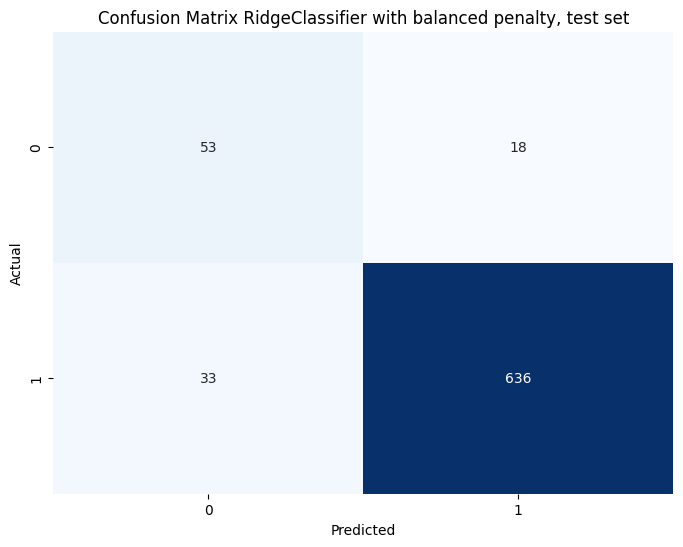

In [65]:
# Create the model with class weights
ridge_classifier = RidgeClassifier(
    alpha=1.0,  # Regularization strength
    class_weight='balanced'  # Adjust weights inversely proportional to class frequencies
)

# Fit the model
ridge_classifier.fit(X_train, y_train)
y_pred = ridge_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.4f}")
plot_conf_matrix(conf_matrix, y_test, "RidgeClassifier with balanced penalty")


Let's try logistic regression

In [66]:
logistic_model = LogisticRegression(
    penalty='l2')

# Fit the model
logistic_model.fit(X_train, y_train)

LogisticRegression()

Accuracy: 0.9527
F1_score: 0.9481


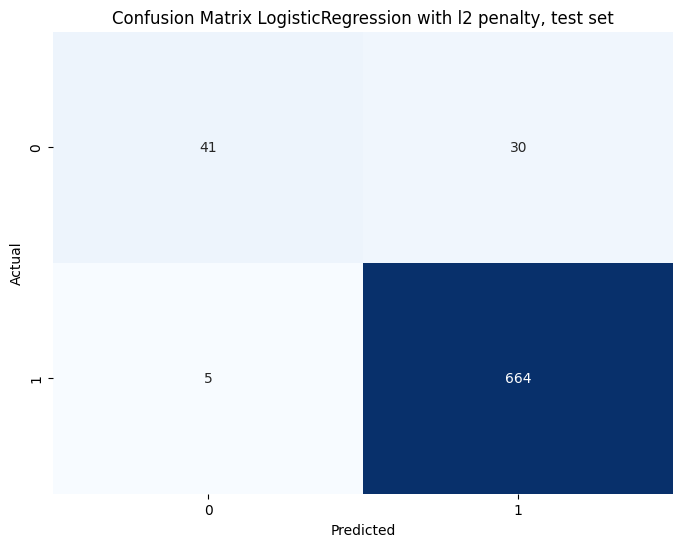

In [70]:
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.4f}")
plot_conf_matrix(conf_matrix, y_test, "LogisticRegression with l2 penalty")

In [71]:
logistic_model = LogisticRegression(
    penalty='l2', 
    C=1.0,  # Inverse of regularization strength
    class_weight='balanced'  
)

# Fit the model
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

Accuracy: 0.9203
F1_score: 0.9251


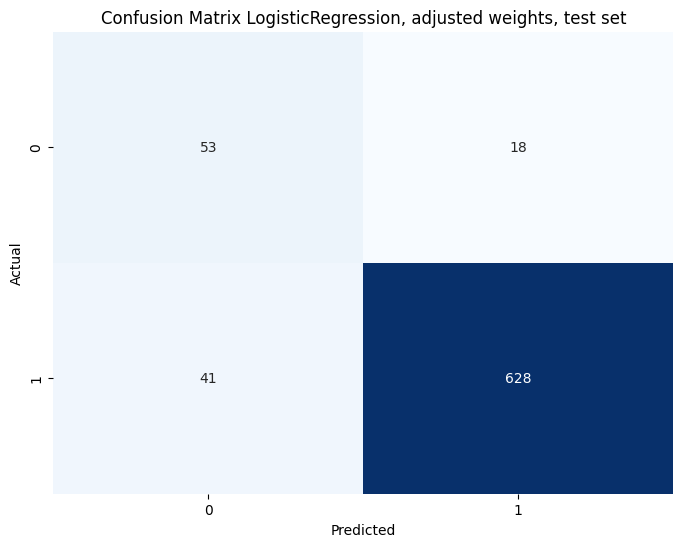

In [74]:
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.4f}")
plot_conf_matrix(conf_matrix, y_test, "LogisticRegression, adjusted weights")

As we can see, overall accuracy dropped, but We achieved better predictions for the "No" class.
Let's try another strategy - resampling - and if it doesn't work, we will play with class weights and different hyperparameters.

The problem is that accuracy in this case doesn't represent each class well, and it's better to use an F1 score.

In [76]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [79]:
undersample = RandomUnderSampler()
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)
smote_enn = SMOTEENN()
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)


X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


print(len(X_resampled))
print(len(X_train))

5510
2960


In [80]:
logistic_model = LogisticRegression(
    penalty='l2')

# Fit the model
logistic_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

Accuracy: 0.9419
F1_score: 0.9419


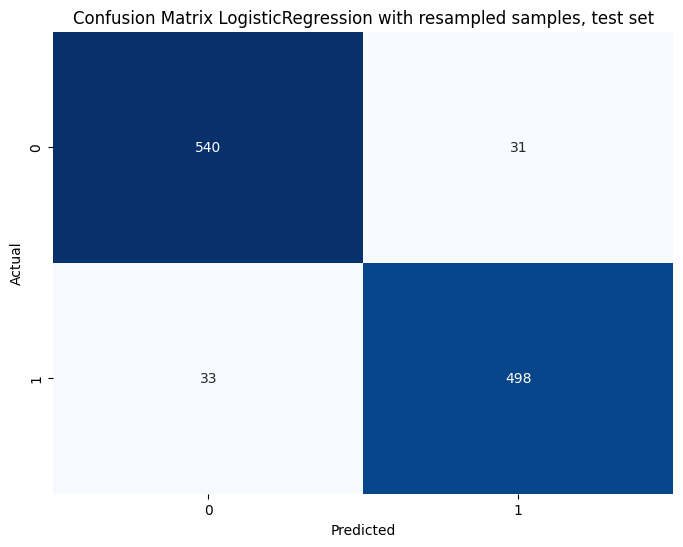

In [83]:
y_pred = logistic_model.predict(X_test_resampled)
accuracy = accuracy_score(y_test_resampled, y_pred)
conf_matrix = confusion_matrix(y_test_resampled, y_pred)
print(f"Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test_resampled, y_pred, average='weighted')
print(f"F1_score: {f1:.4f}")
plot_conf_matrix(conf_matrix, y_test_resampled, "LogisticRegression with resampled samples")


Try random forests

In [84]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

Accuracy: 0.9757
F1_score: 0.9741


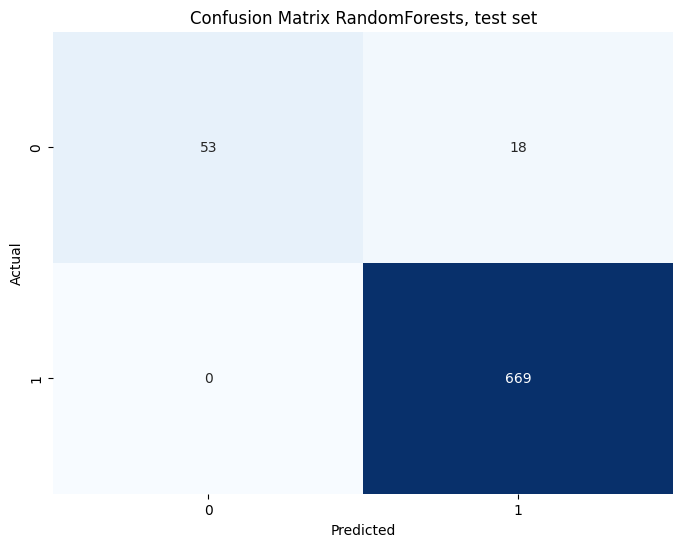

In [87]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.4f}")
plot_conf_matrix(conf_matrix, y_test, "RandomForests")


In [94]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
sfs = SequentialFeatureSelector(model, n_features_to_select=10, direction='forward')
X_sfs = sfs.fit_transform(X, y)

In [95]:
X_sfs.shape

(3700, 10)

In [96]:
selected_features = sfs.get_support()

# Get the names of the selected features if X is a DataFrame
if isinstance(X, pd.DataFrame):
    selected_feature_names = X.columns[selected_features]
    print("Selected Features: ", selected_feature_names)

Selected Features:  Index(['UKL', 'CDx', 'TRE', 'GJAH_rrr', 'BJZHD_ggg', 'BJZHD_hh', 'BJZHD_kkk',
       'BJZHD_lll', 'BJZHD_mmm', 'VOL_t'],
      dtype='object')


In [97]:
model = LogisticRegression()
sfs = SequentialFeatureSelector(model, n_features_to_select=10, direction='backward')
X_sfs = sfs.fit_transform(X, y)
selected_features = sfs.get_support()

# Get the names of the selected features if X is a DataFrame
if isinstance(X, pd.DataFrame):
    selected_feature_names = X.columns[selected_features]
    print("Selected Features: ", selected_feature_names)

Selected Features:  Index(['UKL', 'TRE', 'HUI_rrr', 'BJZHD_hh', 'BJZHD_mmm', 'BJZHD_sss',
       'BJZHD_zzz', 'ZUB_t', 'VOL_t', 'ZIK_is_missing_True'],
      dtype='object')


### Random forests seem to perform the best out-of-the-box. We can try to enhance them by doing feature selection - only looking at N features at each split.

In [92]:
for l in range(1, len(predictors), 5):
    rf = RandomForestClassifier(n_estimators=100, max_features=l, random_state=42)
    print(l, "features")
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1_score: {f1:.4f}")
    # plot_conf_matrix(conf_matrix, y_test, "RandomForests")

1 features
Accuracy: 0.9730
F1_score: 0.9710
6 features
Accuracy: 0.9757
F1_score: 0.9741
11 features
Accuracy: 0.9743
F1_score: 0.9725
16 features
Accuracy: 0.9743
F1_score: 0.9725
21 features
Accuracy: 0.9757
F1_score: 0.9741
26 features
Accuracy: 0.9743
F1_score: 0.9725
31 features
Accuracy: 0.9730
F1_score: 0.9710


Looking at 6 or 26 features is most helpful!

What if the relationship is not even linear?

Check if the relationship is linear, if the variances are equal, if the covariances are equal, etc.

Maybe try Lasso regression, too many features, maybe we can somehow do feature selection

Please provide clear description about your approach. For instance, if you chose a particular model, what was the reason behind that? Also describe your findings and state the challenges you faced with the dataset and how you overcame them.

We expect your submission to be a reflection of your methodical approach and attention to detail.